<a href="https://colab.research.google.com/github/minamocake/Economic_Indicators_and_Charts/blob/master/Copy_of_NeuralHW2_1_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.6 MB/s eta 0:00:00


Finding minimal charge stimulation pattern...
Testing various single pulse combinations...


WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([-70.        , -69.77932535, -69.55994867, ..., -75.942831  ,
       -75.94293322, -75.9430357 ]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([-70.        , -69.77932535, -69.55994867, ..., -75.942831  ,
       -75.94293322, -75.9430357 ]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Successful: Amplitude = 3.00 nA, Width = 1.80 ms, Charge = 5.40 nA·ms
Successful: Amplitude = 3.00 nA, Width = 2.00 ms, Charge = 6.00 nA·ms
Successful: Amplitude = 3.50 nA, Width = 1.60 ms, Charge = 5.60 nA·ms
Successful: Amplitude = 3.50 nA, Width = 1.80 ms, Charge = 6.30 nA·ms
Successful: Amplitude = 3.50 nA, Width = 2.00 ms, Charge = 7.00 nA·ms
Successful: Amplitude = 4.00 nA, Width = 1.20 ms, Charge = 4.76 nA·ms
Successful: Amplitude = 4.00 nA, Width = 1.40 ms, Charge = 5.60 nA·ms
Successful: Amplitude = 4.00 nA, Width = 1.60 ms, Charge = 6.40 nA·ms
Successful: Amplitude = 4.00 nA, Width = 1.80 ms, Charge = 7.20 nA·ms
Successful: Amplitude = 4.00 nA, Width = 2.00 ms, Charge = 8.00 nA·ms
Successful: Amplitude = 4.50 nA, Width = 1.00 ms, Charge = 4.50 nA·ms
Successful: Amplitude = 4.50 nA, Width = 1.20 ms, Charge = 5.36 nA·ms
Successful: Amplitude = 4.50 nA, Width = 1.40 ms, Charge = 6.30 nA·ms
Successful: Amplitude = 4.50 nA, Width = 1.60 ms, Charge = 7.20 nA·ms
Successful: Amplitud

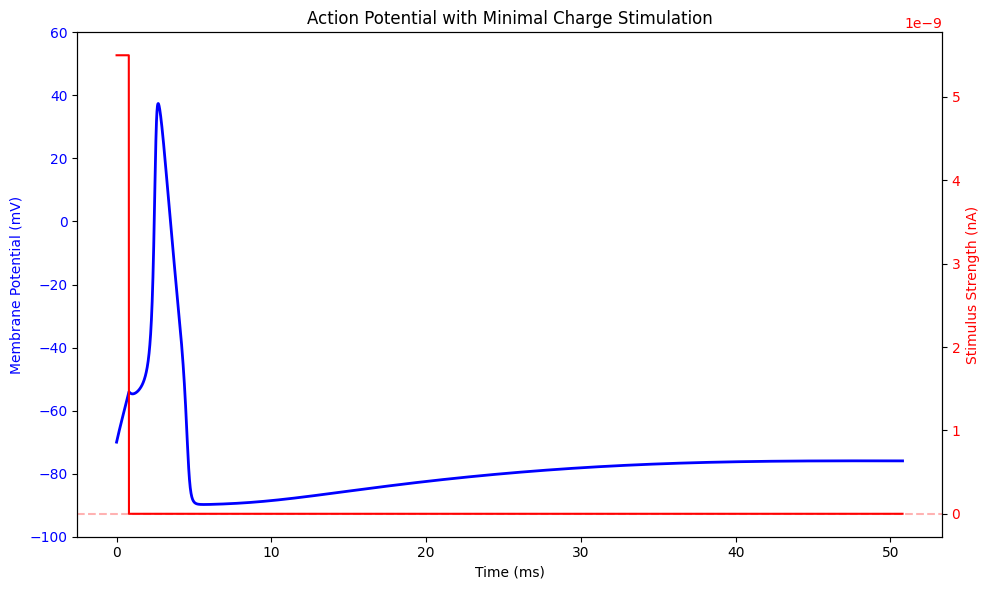

In [ ]:
# Import necessary libraries
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Set up the simulation parameters
defaultclock.dt = 0.01*ms  # Simulation time step

# Hodgkin-Huxley model parameters
area = 20000*umetre**2  # Cell membrane area
Cm = 1*ufarad*cm**-2 * area  # Membrane capacitance
gl = 5e-5*siemens*cm**-2 * area  # Leak conductance
El = -70*mV  # Leak/resting reversal potential
EK = -90*mV  # Potassium reversal potential
ENa = 50*mV  # Sodium reversal potential
g_na = 100*msiemens*cm**-2 * area  # Sodium conductance
g_kd = 30*msiemens*cm**-2 * area  # Potassium conductance

# Differential equations for Hodgkin-Huxley model
eqs = '''
dv/dt = (gl*(El-v) + g_na*m**3*h*(ENa-v) + g_kd*n**4*(EK-v) + I)/Cm : volt
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1
alpha_m = 0.1/mV * 10*mV/exprel(-(v+40*mV)/(10*mV))/ms : Hz
beta_m = 4 * exp(-(v+65*mV)/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-(v+65*mV)/(20*mV))/ms : Hz
beta_h = 1/(exp(-(v+35*mV)/(10*mV))+1)/ms : Hz
alpha_n = 0.01/mV * 10*mV/exprel(-(v+55*mV)/(10*mV))/ms : Hz
beta_n = 0.125 * exp(-(v+65*mV)/(80*mV))/ms : Hz
I : amp
'''

def test_stimulation(amplitude, pulse_width, num_pulses=1, pulse_interval=5*ms):
    """
    Test a stimulation pattern and return whether it produced an action potential and the total charge.

    Parameters:
    amplitude : current amplitude (in ampere)
    pulse_width : duration of each pulse (in ms)
    num_pulses : number of pulses to deliver
    pulse_interval : time between the start of each pulse (in ms)

    Returns:
    tuple: (produced_ap, total_charge, membrane_potential, time, stimulus)
    """
    # Create a neuron using the Hodgkin-Huxley model
    neuron = NeuronGroup(1, eqs, method='exponential_euler')

    # Initialize the neuron to resting state
    neuron.v = El
    neuron.m = 0.05
    neuron.h = 0.6
    neuron.n = 0.32

    # Record the membrane potential
    M = StateMonitor(neuron, 'v', record=0)

    # Calculate simulation time to ensure neuron returns to rest
    rest_time = 50*ms  # Extra time to observe full AP and return to rest
    if num_pulses > 1:
        simulation_time = (pulse_interval * (num_pulses-1) + pulse_width + rest_time)
    else:
        simulation_time = (pulse_width + rest_time)

    # Create the stimulus array - Make sure it has the right size
    steps_per_ms = int(1*ms / defaultclock.dt)
    simulation_steps = int(simulation_time / defaultclock.dt)
    stimulus = np.zeros(simulation_steps) * amp

    # Set up the pulse train
    pulse_width_steps = int(pulse_width / defaultclock.dt)
    for i in range(num_pulses):
        start_step = int(i * pulse_interval / defaultclock.dt)
        end_step = start_step + pulse_width_steps
        # Make sure we don't exceed array bounds
        end_step = min(end_step, simulation_steps)
        if start_step < simulation_steps:
            stimulus[start_step:end_step] = amplitude

    # Run the simulation with a custom input current
    @network_operation(dt=defaultclock.dt)
    def update_input_current(t):
        # Calculate the current index based on time
        current_idx = int(t / defaultclock.dt)
        if current_idx < len(stimulus):
            neuron.I = stimulus[current_idx]
        else:
            neuron.I = 0 * amp

    # Create a network and run the simulation
    net = Network(neuron, M, update_input_current)
    net.run(simulation_time)

    # Calculate the total charge (integral of |I|*dt)
    total_charge = np.sum(np.abs(stimulus)) * defaultclock.dt

    # Determine if an action potential occurred (threshold crossing at -20 mV)
    produced_ap = np.max(M.v[0]/mV) > -20

    # Extract time values from the state monitor (in ms)
    time_values = M.t/ms

    # Return membrane potential, time, and stimulus values
    # Ensure stimulus array matches the length of the recorded data
    stimulus_for_plot = np.zeros_like(time_values) * amp
    for i in range(min(len(stimulus), len(time_values))):
        stimulus_for_plot[i] = stimulus[i]

    return produced_ap, total_charge, M.v[0]/mV, time_values, stimulus_for_plot/amp

def find_minimal_charge():
    """
    Find the stimulation with minimal charge that produces an action potential.
    Tests various amplitude and pulse width combinations.

    Returns:
    tuple: (min_amplitude, min_pulse_width, min_num_pulses, min_interval, min_charge, v, t, stim)
    """
    # List to store (amplitude, pulse_width, charge) for successful stimulations
    successful_stims = []

    # Test a range of amplitudes and pulse widths for single pulses
    print("Testing various single pulse combinations...")

    # Test ranges
    amplitudes = np.linspace(2, 6, 9) * nA  # From 2nA to 6nA
    pulse_widths = np.linspace(0.2, 2.0, 10) * ms  # From 0.2ms to 2.0ms

    for amp in amplitudes:
        for width in pulse_widths:
            produced_ap, charge, v, t, stim = test_stimulation(amp, width)
            if produced_ap:
                successful_stims.append((amp, width, 1, 0*ms, charge, v, t, stim))
                print(f"Successful: Amplitude = {amp/nA:.2f} nA, Width = {width/ms:.2f} ms, Charge = {charge/(nA*ms):.2f} nA·ms")

    # Find the stimulation with minimal charge
    if successful_stims:
        min_params = min(successful_stims, key=lambda x: x[4])
        min_amplitude, min_pulse_width, min_num_pulses, min_interval, min_charge, v, t, stim = min_params
        print(f"\nMinimal single-pulse charge: {min_charge/(nA*ms):.2f} nA·ms with {min_amplitude/nA:.2f} nA and {min_pulse_width/ms:.2f} ms")
    else:
        print("No successful single-pulse stimulations found.")
        return None

    # Test two-pulse stimulation
    print("\nTesting two-pulse stimulation...")

    # Find a good subthreshold amplitude (about 80-90% of the threshold)
    subthreshold_amp = min_amplitude * 0.85

    # Test various pulse intervals with two pulses
    intervals = np.linspace(2, 8, 7) * ms  # From 2ms to 8ms

    for interval in intervals:
        produced_ap, charge, v, t, stim = test_stimulation(
            subthreshold_amp, min_pulse_width, 2, interval)

        if produced_ap:
            successful_stims.append((subthreshold_amp, min_pulse_width, 2, interval, charge, v, t, stim))
            print(f"Successful two-pulse: Interval = {interval/ms:.2f} ms, Charge = {charge/(nA*ms):.2f} nA·ms")

    # Find the overall stimulation with minimal charge
    min_params = min(successful_stims, key=lambda x: x[4])

    return min_params

# Find the stimulation with minimal charge
print("Finding minimal charge stimulation pattern...")
result = find_minimal_charge()

if result:
    min_amplitude, min_pulse_width, min_num_pulses, min_interval, min_charge, v, t, stim = result

    # Display results
    print("\nFinal Results:")
    print(f"Minimal charge stimulation parameters:")
    print(f"Amplitude: {min_amplitude/nA:.2f} nA")
    print(f"Pulse width: {min_pulse_width/ms:.2f} ms")
    print(f"Number of pulses: {min_num_pulses}")
    if min_num_pulses > 1:
        print(f"Pulse interval: {min_interval/ms:.2f} ms")
    print(f"Total charge: {min_charge/(nA*ms):.2f} nA·ms")

    # Plot the results using a single chart with two y-axes
    plt.figure(figsize=(10, 6))

    # Primary y-axis for membrane potential
    ax1 = plt.gca()
    ax1.plot(t, v, 'b-', linewidth=2)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane Potential (mV)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(-100, 60)  # Set appropriate y-limits for membrane potential

    # Secondary y-axis for stimulus
    ax2 = ax1.twinx()
    ax2.plot(t, stim, 'r-', linewidth=1.5)
    ax2.set_ylabel('Stimulus Strength (nA)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add a horizontal line at 0 for stimulus
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)

    # Title
    plt.title('Action Potential with Minimal Charge Stimulation')

    plt.tight_layout()
    plt.savefig('action_potential_minimal_charge.png', dpi=300)
    plt.show()
else:
    print("Failed to find a successful stimulation pattern.")